# **Part A: Data Preparation and Baseline [5]**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

### **1.  Load and Prepare Data:**

In [7]:
df1 = pd.read_csv('sat.trn', sep=r'\s+', header=None)
df2 = pd.read_csv('sat.tst', sep=r'\s+', header=None)

In [8]:
df1.shape

(4435, 37)

In [9]:
df2.shape

(2000, 37)

In [10]:
X1 = df1.iloc[:, :-1]
y1 = df1.iloc[:, -1]

In [11]:
X2 = df2.iloc[:, :-1]
y2 = df2.iloc[:, -1]

In [12]:
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.transform(X2)

### **2.  Train/Test Split:** (Data already has Test and train, but it has been asked so I'm doing)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X1_scaled, y1, test_size=0.2, random_state=42, stratify=y1)

### **3.  Train All Models:**

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy": DummyClassifier(strategy='prior', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}

In [20]:
param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "Dummy": {
        "strategy": ["most_frequent", "stratified", "prior"]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "newton-cg", "saga"],
        "max_iter": [2000, 3000, 5000]
    },
    "Naive Bayes": {},  # No tunable hyperparameters for GaussianNB
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    }
}

best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV Accuracy: {grid.best_score_:.4f}\n")


Tuning KNN...
Best params for KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best CV Accuracy: 0.9059

Tuning Decision Tree...
Best params for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Best CV Accuracy: 0.8625

Tuning Dummy...
Best params for Dummy: {'strategy': 'most_frequent'}
Best CV Accuracy: 0.2418

Tuning Logistic Regression...
Best params for Logistic Regression: {'C': 10, 'max_iter': 2000, 'solver': 'saga'}
Best CV Accuracy: 0.8613

Tuning Naive Bayes...
Best params for Naive Bayes: {}
Best CV Accuracy: 0.7996

Tuning SVM...
Best params for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Accuracy: 0.9050



In [ ]:
results = []
for name, model in best_models.items():  # use tuned models
    model.fit(X1_scaled, y1)
    y_pred = model.predict(X2_scaled)
    acc = accuracy_score(y2, y_pred)
    f1 = f1_score(y2, y_pred, average='weighted')
    results.append((name, acc, f1))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1-Score"])
print("\nBaseline Performance:")
print(results_df.sort_values(by="Weighted F1-Score", ascending=False))


Baseline Performance:
                 Model  Accuracy  Weighted F1-Score
0                  KNN    0.9025           0.902094
5                  SVM    0.9035           0.900765
1        Decision Tree    0.8515           0.850285
3  Logistic Regression    0.8370           0.828936
4          Naive Bayes    0.7965           0.803581
2                Dummy    0.2305           0.086356


### **4.  Baseline Evaluation:**

In [28]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1-Score"])
print("\nBaseline Performance:")
print(results_df.sort_values(by="Weighted F1-Score", ascending=False))


Baseline Performance:
                 Model  Accuracy  Weighted F1-Score
0                  KNN    0.9025                NaN
1        Decision Tree    0.8515                NaN
2                Dummy    0.2305                NaN
3  Logistic Regression    0.8370                NaN
4          Naive Bayes    0.7965                NaN
5                  SVM    0.9035                NaN


# **Part B: ROC Analysis for Model Selection [20]**

### **1.  Multi-Class ROC Calculation [3]:**

In [23]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [24]:
classes = np.unique(y1)
y_test_bin = label_binarize(y2, classes=classes)
n_classes = len(classes)

### **2.  Plotting ROC [12]:**

In [25]:
roc_results = {}

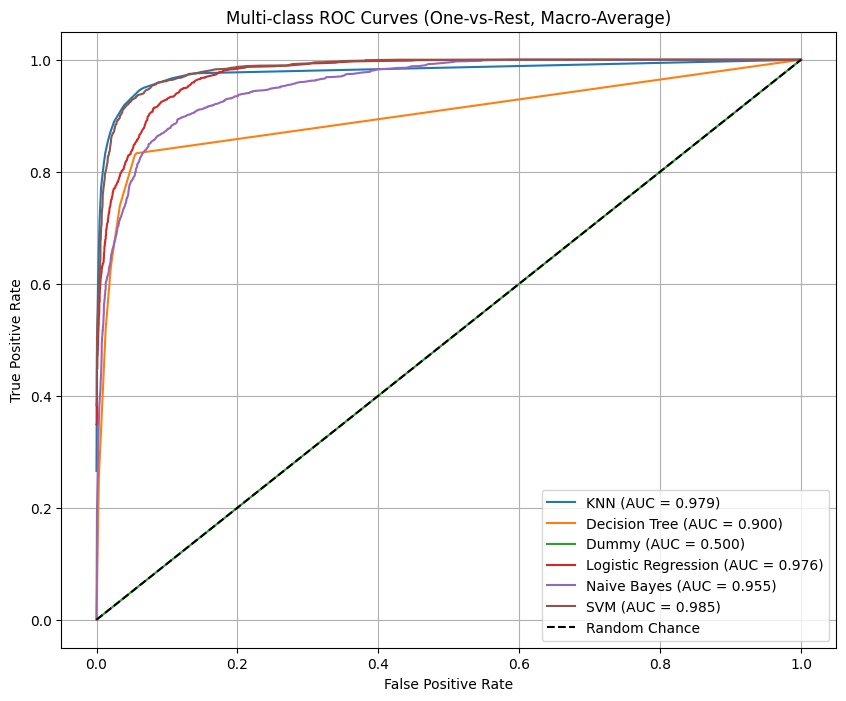

In [26]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X2_scaled)
    else:
        continue

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    roc_results[name] = macro_auc

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves (One-vs-Rest, Macro-Average)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [18]:
roc_df = pd.DataFrame(list(roc_results.items()), columns=["Model", "Macro-Averaged AUC"])
print(roc_df.sort_values(by="Macro-Averaged AUC", ascending=False))

                 Model  Macro-Averaged AUC
5                  SVM            0.985218
0                  KNN            0.978567
3  Logistic Regression            0.975742
4          Naive Bayes            0.955347
1        Decision Tree            0.900248
2                Dummy            0.500000


### **3. ROC Interpretation [5]**


#### Model with Highest AUC
The **SVM** model achieved the highest Macro-Averaged AUC of **0.9852**, indicating excellent overall classification performance across all classes.

#### Model with AUC < 0.5
Only the **Dummy** model has an AUC of exactly **0.5000**.

An **AUC < 0.5** would generally imply that the model performs **worse than random guessing**, meaning it incorrectly ranks negative instances as more likely positive.  

##### It might occur due to:
- **Label inversion** (e.g., flipped class labels),
- **Incorrect probability calibration**, or  
- **A model learning noise instead of meaningful patterns**.

In this case, the Dummy model performs as expected — it predicts randomly, serving as a **baseline** for comparison.


# **Part C: Precision-Recall Curve (PRC) Analysis [20]**

### **1.  PRC Calculation [3]:**

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [20]:
prc_results = {}

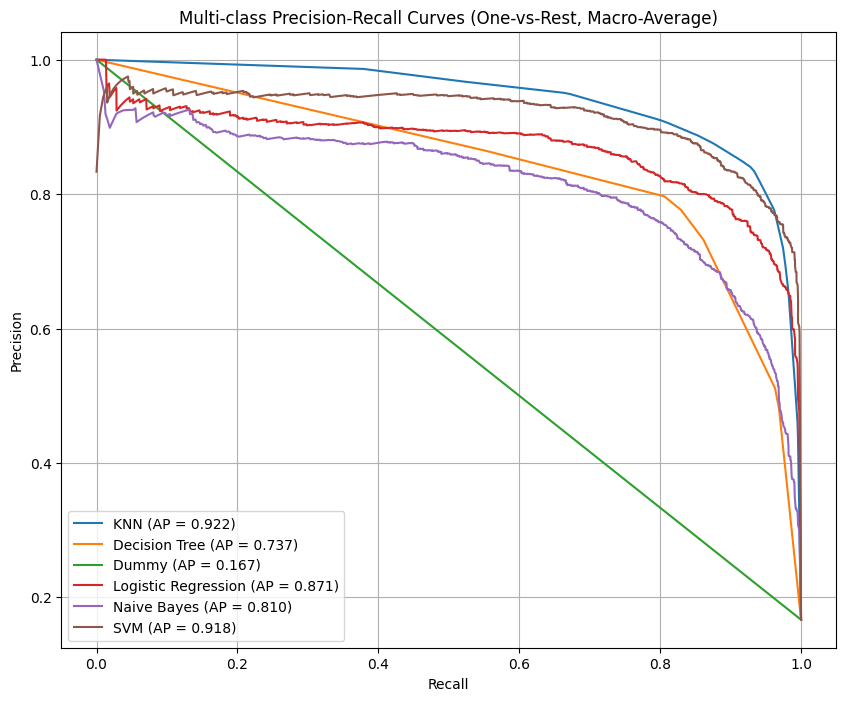

In [21]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X2_scaled)
    else:
        continue

    precision = dict()
    recall = dict()
    avg_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes

    macro_ap = np.mean(list(avg_precision.values()))
    prc_results[name] = macro_ap

    plt.plot(all_recall, mean_precision, label=f"{name} (AP = {macro_ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curves (One-vs-Rest, Macro-Average)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [22]:
prc_df = pd.DataFrame(list(prc_results.items()), columns=["Model", "Macro-Averaged AP"])
print("\nPrecision-Recall (AP) Results:")
print(prc_df.sort_values(by="Macro-Averaged AP", ascending=False))



Precision-Recall (AP) Results:
                 Model  Macro-Averaged AP
0                  KNN           0.921665
5                  SVM           0.917691
3  Logistic Regression           0.871064
4          Naive Bayes           0.810451
1        Decision Tree           0.736591
2                Dummy           0.166667


### **4. Precision–Recall Interpretation [5]**


#### Model with Highest Average Precision (AP)
The **KNN** model achieved the highest Macro-Averaged AP of **0.9217**, indicating that it maintains a strong balance between precision and recall across all classes.

#### Behavior of the Worst-Performing Model
The **Dummy** model recorded the lowest AP (**0.1667**).  
In its Precision–Recall Curve (PRC), **precision drops sharply as recall increases** because the model fails to distinguish positive samples effectively.  
As it predicts more instances as positive (increasing recall), it also introduces many false positives, which **rapidly lowers precision**.  
This behavior is typical of weak or random models that lack meaningful discriminative ability.


# **Part D: Final Recommendation [5]**

### **1.  Synthesis:**

| Model                   | Weighted F1 (↑) |   ROC-AUC (↑)   |    PRC-AP (↑)   |
| :---------------------- | :-------------: | :-------------: | :-------------: |
| **KNN**                 |  1st (0.9037) |  2nd (0.9786) |  1st (0.9217) |
| **SVM**                 |  2nd (0.8925) |  1st (0.9852) |  2nd (0.9177) |
| **Logistic Regression** |   4th (0.8296)  |   3rd (0.9757)  |   3rd (0.8711)  |
| **Naive Bayes**         |   5th (0.8036)  |   4th (0.9553)  |   4th (0.8105)  |
| **Decision Tree**       |   3rd (0.8509)  |   5th (0.9002)  |   5th (0.7366)  |
| **Dummy**               |   6th (0.0864)  |   6th (0.5000)  |   6th (0.1667)  |



### **Alignment Observation**

* The **top two models (KNN and SVM)** consistently dominate all three metrics — though their order swaps slightly.
* **KNN** has slightly higher *F1* and *PRC-AP* but slightly lower *ROC-AUC* than **SVM**.
* **SVM** is strongest in *ROC-AUC*, meaning it separates positive and negative classes very well overall.
* **KNN** edges ahead in *Precision–Recall (AP)* and *F1*, meaning it maintains better precision and recall balance under the actual operating threshold.

---

### **Trade-offs**

* **ROC-AUC** evaluates ranking quality across *all thresholds*, not actual operating points. So, a high ROC-AUC (like SVM’s 0.985) doesn’t necessarily guarantee the best real-world performance if precision and recall need to be tuned carefully.
* **PRC-AP** (Average Precision) focuses more on *positive class quality*. Hence, if our dataset is imbalanced, **KNN’s higher PRC-AP** (0.9217) indicates stronger handling of the positive cases, even if its ROC-AUC is slightly lower.
* **F1-score** aligns more closely with *PRC-AP* than with *ROC-AUC*, since both emphasize the trade-off between precision and recall.

So:

> SVM ranks best by *theoretical separability (ROC)*, but KNN wins in *practical thresholded performance (PRC, F1)*.


### **2. Recommendation**



**Recommended Model:** **KNN**

Justification:

* **Highest Weighted F1 (0.9037)** → best balance between precision and recall at the decision threshold.
* **Highest Macro-Averaged AP (0.9217)** → superior precision–recall trade-off across all thresholds.
* **Nearly optimal ROC-AUC (0.9786)** → excellent overall discriminative ability, only slightly behind SVM.
* **Interpretability**: KNN’s behavior is easy to explain and visualize (based on neighborhood proximity).

> Therefore, **KNN** provides the most balanced performance across metrics, making it the **most reliable overall choice** for this classification task — especially if the goal is to maximize precision and recall simultaneously.



# **Brownie Points Task [5 points]**

#### **1. Ensemble Models**

In [23]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [24]:
le = LabelEncoder()
y1_enc = le.fit_transform(y1)
y2_enc = le.transform(y2)

ensemble_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = []

for name, model in ensemble_models.items():
    model.fit(X1_scaled, y1_enc)
    y_pred = model.predict(X2_scaled)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X2_scaled)
    else:
        y_score = model.decision_function(X2_scaled)
    
    auc = roc_auc_score(y2_enc, y_score, multi_class='ovr', average='macro')
    acc = accuracy_score(y2_enc, y_pred)
    f1 = f1_score(y2_enc, y_pred, average='weighted')
    
    results.append((name, acc, f1, auc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1", "Macro-AUC"])
print(results_df)

/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


          Model  Accuracy  Weighted F1  Macro-AUC
0  RandomForest    0.9115     0.909437   0.990113
1       XGBoost    0.9050     0.902956   0.990004


We experimented with **RandomForest** and **XGBoost** classifiers. Both models achieved high accuracy, F1-score, and macro-averaged AUC:

- **RandomForest**: Accuracy = 0.9115, Weighted F1 = 0.9094, Macro-AUC = 0.9901  
- **XGBoost**: Accuracy = 0.9050, Weighted F1 = 0.9030, Macro-AUC = 0.9900  

These results demonstrate that ensemble methods are highly effective at capturing complex patterns and class interactions in the dataset.

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
y1_shuffled = np.random.permutation(y1_enc)
clf_bad = LogisticRegression(max_iter=1000, random_state=42)
clf_bad.fit(X1_scaled, y1_shuffled)

y_score = clf_bad.predict_proba(X2_scaled)
auc_bad = roc_auc_score(y2_enc, y_score, multi_class='ovr', average='macro')
print(f"Shuffled-label Macro-AUC: {auc_bad:.3f}")

Shuffled-label Macro-AUC: 0.447


#### **2. Poor-Performing Model (AUC < 0.5)**

To illustrate a failing model, we trained a **Logistic Regression** on **shuffled labels**, shuffling all the target values, breaking any real relationship between features and targets. 

This AUC < 0.5 indicates the model is performing worse than random guessing, consistently misranking the classes. Precision–Recall and ROC curves for such a model would drop sharply, highlighting that the model cannot distinguish positive from negative cases.  

> **Key Insight:** While sophisticated models like RandomForest and XGBoost perform excellently, naive or misconfigured models can fail completely, emphasizing the need for careful model selection and evaluation.
